In [11]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import cv2
import random

class CTSliceDataset(Dataset):
    def __init__(self, metadata_csv, slice_range=(24, 40), img_size=224, augment=False):
        self.df = pd.read_csv(metadata_csv)
        self.slice_range = slice_range
        self.img_size = img_size
        self.augment = augment

        # Filter: CT must exist, label must be valid
        self.df = self.df[self.df['label'].isin(['Stage II', 'Stage III', 'Stage IV'])].copy()
        self.df['ct'] = self.df['ct'].astype(str)
        self.df = self.df[self.df['ct'].str.endswith(".npy")]

        self.label_map = {'Stage II': 0, 'Stage III': 1, 'Stage IV': 2}
        self.samples = []

        for _, row in self.df.iterrows():
            label = self.label_map[row['label']]
            volume_path = row['ct']
            if not os.path.exists(volume_path): continue

            volume = np.load(volume_path)
            start, end = self.slice_range
            for i in range(start, end):
                if i >= volume.shape[0]: continue
                self.samples.append((volume[i], label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]

        # Resize image to (224x224)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0

        # Data augmentation (optional)
        if self.augment:
            if random.random() < 0.5:
                image = np.flip(image, axis=1).copy()
            if random.random() < 0.5:
                image = np.flip(image, axis=0).copy()

        # Add channel dimension
        image = np.expand_dims(image, axis=0)
        return torch.tensor(image), torch.tensor(label)


In [13]:
dataset = CTSliceDataset(r"F:\INT500\CLAUDE\processed_data\metadata.csv", augment=True)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# === Load Dataset ===
dataset = CTSliceDataset(r"F:\INT500\CLAUDE\processed_data\metadata.csv", augment=True)
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# === Load ResNet18 (2D) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify input & output layers
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 channel
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes

model = model.to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# === Training Loop ===
EPOCHS = 30
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    train_loss, train_preds, train_labels = [], [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # === Validation ===
    model.eval()
    val_loss, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    scheduler.step()

    print(f"\n⏱ Epoch Time: {time.time() - start_time:.2f}s")
    print(f"📉 Train Loss: {sum(train_loss)/len(train_loss):.4f} | 🟢 Train Acc: {train_acc:.4f}")
    print(f"📉 Val Loss:   {sum(val_loss)/len(val_loss):.4f} | 🔵 Val Acc:   {val_acc:.4f}")

print("✅ Training complete!")

D:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:03<00:00,  2.88s/it]



⏱ Epoch Time: 133.82s
📉 Train Loss: 0.6870 | 🟢 Train Acc: 0.7146
📉 Val Loss:   1.4012 | 🔵 Val Acc:   0.4240


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:04<00:00,  2.90s/it]



⏱ Epoch Time: 134.80s
📉 Train Loss: 0.2139 | 🟢 Train Acc: 0.9453
📉 Val Loss:   0.2893 | 🔵 Val Acc:   0.9035


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:04<00:00,  2.90s/it]



⏱ Epoch Time: 134.66s
📉 Train Loss: 0.0983 | 🟢 Train Acc: 0.9723
📉 Val Loss:   0.0810 | 🔵 Val Acc:   0.9737


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.92s/it]



⏱ Epoch Time: 135.75s
📉 Train Loss: 0.0613 | 🟢 Train Acc: 0.9810
📉 Val Loss:   0.0671 | 🔵 Val Acc:   0.9883


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.92s/it]



⏱ Epoch Time: 135.40s
📉 Train Loss: 0.0383 | 🟢 Train Acc: 0.9883
📉 Val Loss:   0.0563 | 🔵 Val Acc:   0.9883


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:04<00:00,  2.90s/it]



⏱ Epoch Time: 134.79s
📉 Train Loss: 0.0213 | 🟢 Train Acc: 0.9942
📉 Val Loss:   0.0702 | 🔵 Val Acc:   0.9825


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:03<00:00,  2.87s/it]



⏱ Epoch Time: 133.60s
📉 Train Loss: 0.0108 | 🟢 Train Acc: 0.9985
📉 Val Loss:   0.0520 | 🔵 Val Acc:   0.9883


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:04<00:00,  2.90s/it]



⏱ Epoch Time: 134.69s
📉 Train Loss: 0.0097 | 🟢 Train Acc: 0.9985
📉 Val Loss:   0.0534 | 🔵 Val Acc:   0.9854


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:03<00:00,  2.88s/it]



⏱ Epoch Time: 133.44s
📉 Train Loss: 0.0073 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0550 | 🔵 Val Acc:   0.9854


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:03<00:00,  2.88s/it]



⏱ Epoch Time: 133.83s
📉 Train Loss: 0.0057 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0501 | 🔵 Val Acc:   0.9883


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.92s/it]



⏱ Epoch Time: 135.41s
📉 Train Loss: 0.0048 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0454 | 🔵 Val Acc:   0.9912


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:18<00:00,  3.23s/it]



⏱ Epoch Time: 148.93s
📉 Train Loss: 0.0043 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0447 | 🔵 Val Acc:   0.9912


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.93s/it]



⏱ Epoch Time: 135.97s
📉 Train Loss: 0.0053 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0465 | 🔵 Val Acc:   0.9883


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:06<00:00,  2.94s/it]



⏱ Epoch Time: 136.56s
📉 Train Loss: 0.0086 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0531 | 🔵 Val Acc:   0.9883


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.93s/it]



⏱ Epoch Time: 135.75s
📉 Train Loss: 0.0037 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0462 | 🔵 Val Acc:   0.9912


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:06<00:00,  2.94s/it]



⏱ Epoch Time: 136.31s
📉 Train Loss: 0.0034 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0535 | 🔵 Val Acc:   0.9912


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.93s/it]



⏱ Epoch Time: 135.88s
📉 Train Loss: 0.0114 | 🟢 Train Acc: 0.9978
📉 Val Loss:   0.0433 | 🔵 Val Acc:   0.9912


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:06<00:00,  2.93s/it]



⏱ Epoch Time: 136.05s
📉 Train Loss: 0.0047 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0379 | 🔵 Val Acc:   0.9912


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:06<00:00,  2.93s/it]



⏱ Epoch Time: 136.16s
📉 Train Loss: 0.0051 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0345 | 🔵 Val Acc:   0.9912


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:06<00:00,  2.94s/it]



⏱ Epoch Time: 136.60s
📉 Train Loss: 0.0039 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0302 | 🔵 Val Acc:   0.9912


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.93s/it]



⏱ Epoch Time: 135.71s
📉 Train Loss: 0.0020 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0227 | 🔵 Val Acc:   0.9912


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.92s/it]



⏱ Epoch Time: 135.41s
📉 Train Loss: 0.0023 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0359 | 🔵 Val Acc:   0.9912


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.91s/it]



⏱ Epoch Time: 135.18s
📉 Train Loss: 0.0031 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0405 | 🔵 Val Acc:   0.9912


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.91s/it]



⏱ Epoch Time: 134.99s
📉 Train Loss: 0.0021 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0446 | 🔵 Val Acc:   0.9912


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.92s/it]



⏱ Epoch Time: 135.45s
📉 Train Loss: 0.0034 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0521 | 🔵 Val Acc:   0.9912


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:04<00:00,  2.90s/it]



⏱ Epoch Time: 135.43s
📉 Train Loss: 0.0015 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0583 | 🔵 Val Acc:   0.9912


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:25<00:00,  3.39s/it]



⏱ Epoch Time: 156.92s
📉 Train Loss: 0.0017 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0507 | 🔵 Val Acc:   0.9912


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:25<00:00,  3.39s/it]



⏱ Epoch Time: 157.06s
📉 Train Loss: 0.0015 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0508 | 🔵 Val Acc:   0.9912


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:13<00:00,  3.11s/it]



⏱ Epoch Time: 143.55s
📉 Train Loss: 0.0016 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0543 | 🔵 Val Acc:   0.9912


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:05<00:00,  2.91s/it]



⏱ Epoch Time: 137.08s
📉 Train Loss: 0.0019 | 🟢 Train Acc: 1.0000
📉 Val Loss:   0.0375 | 🔵 Val Acc:   0.9912
✅ Training complete!


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchvision import models
from torchvision.transforms import Normalize
import torch.nn.functional as F

def show_gradcam(model, image_tensor, label, device, class_names=["Stage II", "Stage III", "Stage IV"]):
    model.eval()
    image_tensor = image_tensor.to(device).unsqueeze(0)  # [1, 1, 224, 224]

    # === Hook last conv layer ===
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    hook = model.layer4.register_forward_hook(forward_hook)
    model.layer4.register_backward_hook(backward_hook)

    # === Forward & Backward ===
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    one_hot = torch.zeros_like(output)
    one_hot[0, pred_class] = 1
    output.backward(gradient=one_hot)

    # === Compute Grad-CAM ===
    grad = gradients[0].squeeze(0)      # [C, H, W]
    act = activations[0].squeeze(0)     # [C, H, W]

    weights = grad.mean(dim=[1, 2])     # [C]
    cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = cam.cpu().detach().numpy()
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / cam.max() if cam.max() != 0 else cam
    cam = cv2.resize(cam, (224, 224))

    # === Original image ===
    img = image_tensor.squeeze().cpu().numpy()  # [224, 224]

    # === Overlay ===
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1]  # BGR to RGB
    overlay = 0.4 * heatmap + 0.6 * np.stack([img*255]*3, axis=2)

    # === Plot ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Slice")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Overlay: Pred = {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

    hook.remove()

In [20]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

def run_gradcam_on_validation(val_loader, model, device, output_dir="gradcam_outputs", class_names=["Stage I", "Stage II", "Stage III"]):
    model.eval()
    for i, (images, labels) in enumerate(tqdm(val_loader, desc="Generating Grad-CAMs")):
        for j in range(images.size(0)):
            image = images[j].unsqueeze(0).to(device)
            label = labels[j].item()

            # === Hook setup ===
            activations, gradients = [], []

            def forward_hook(module, input, output):
                activations.append(output)

            def backward_hook(module, grad_in, grad_out):
                gradients.append(grad_out[0])

            h1 = model.layer4.register_forward_hook(forward_hook)
            h2 = model.layer4.register_backward_hook(backward_hook)

            output = model(image)
            pred_class = output.argmax(dim=1).item()

            one_hot = torch.zeros_like(output)
            one_hot[0, pred_class] = 1
            output.backward(gradient=one_hot)

            grad = gradients[0].squeeze(0)
            act = activations[0].squeeze(0)

            weights = grad.mean(dim=[1, 2])
            cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)
            for k, w in enumerate(weights):
                cam += w * act[k]

            cam = cam.cpu().detach().numpy()
            cam = np.maximum(cam, 0)
            cam = cam / cam.max() if cam.max() != 0 else cam
            cam = cv2.resize(cam, (224, 224))

            # Image prep
            original = images[j].squeeze().cpu().numpy()
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = heatmap[..., ::-1]
            overlay = 0.4 * heatmap + 0.6 * np.stack([original * 255] * 3, axis=2)

            filename = f"sample_{i}_{j}_pred_{class_names[pred_class]}.png"
            filepath = os.path.join(output_dir, filename)
            cv2.imwrite(filepath, overlay.astype(np.uint8))

            # Cleanup
            h1.remove()
            h2.remove()

    print(f"✅ All Grad-CAM overlays saved to: {output_dir}")

D:\Python\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


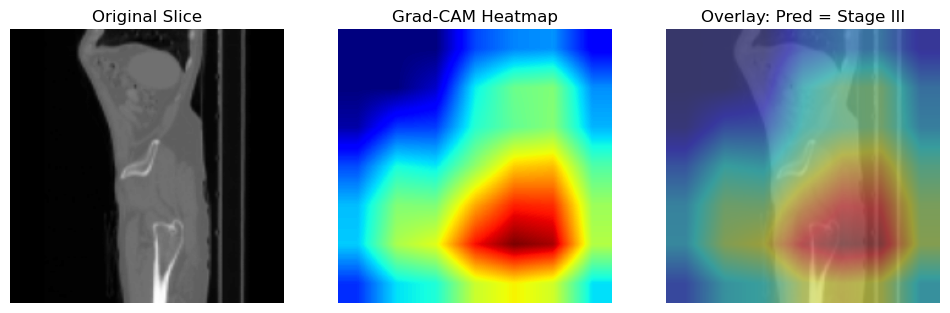

In [18]:
# Pick a test image
image, label = dataset[0]  # or any index
show_gradcam(model, image, label, device)

In [21]:
run_gradcam_on_validation(val_loader, model, device)

Generating Grad-CAMs: 100%|████████████████████████████████████████████████████████████| 11/11 [01:10<00:00,  6.38s/it]

✅ All Grad-CAM overlays saved to: gradcam_outputs


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, val_loader, device, class_names=["Stage II", "Stage III", "Stage IV"], fold=0):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Print metrics
    print(f"\n📊 Fold {fold} Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # === Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Fold {fold} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



📊 Fold 4 Classification Report:

              precision    recall  f1-score   support

    Stage II     1.0000    0.9845    0.9922       129
   Stage III     0.9911    0.9911    0.9911       112
    Stage IV     0.9806    1.0000    0.9902       101

    accuracy                         0.9912       342
   macro avg     0.9906    0.9919    0.9912       342
weighted avg     0.9913    0.9912    0.9912       342



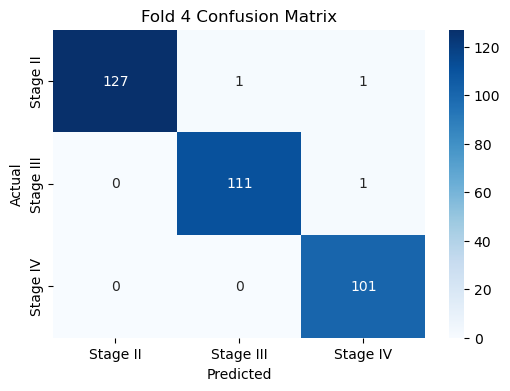

In [24]:
evaluate_model(model, val_loader, device, fold=fold)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# === Dataset ===
dataset = CTSliceDataset(r"F:\INT500\CLAUDE\processed_data\metadata.csv", augment=True)
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# === Build EfficientNetB0 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b0(weights="IMAGENET1K_V1")
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
model = model.to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# === Training ===
EPOCHS = 30
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    train_loss, train_preds, train_labels = [], [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # === Validation ===
    model.eval()
    val_loss, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    scheduler.step()

    print(f"\n⏱ Epoch Time: {time.time() - start_time:.2f}s")
    print(f"📉 Train Loss: {sum(train_loss)/len(train_loss):.4f} | 🟢 Train Acc: {train_acc:.4f}")
    print(f"📉 Val Loss:   {sum(val_loss)/len(val_loss):.4f} | 🔵 Val Acc:   {val_acc:.4f}")

print("✅ Training complete!")


Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:49<00:00,  3.95s/it]



⏱ Epoch Time: 177.70s
📉 Train Loss: 0.9514 | 🟢 Train Acc: 0.5650
📉 Val Loss:   1.1080 | 🔵 Val Acc:   0.3333


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:47<00:00,  3.89s/it]



⏱ Epoch Time: 175.22s
📉 Train Loss: 0.6651 | 🟢 Train Acc: 0.7555
📉 Val Loss:   0.8922 | 🔵 Val Acc:   0.5760


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:47<00:00,  3.90s/it]



⏱ Epoch Time: 175.86s
📉 Train Loss: 0.4238 | 🟢 Train Acc: 0.8723
📉 Val Loss:   0.2931 | 🔵 Val Acc:   0.9152


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:46<00:00,  3.87s/it]



⏱ Epoch Time: 174.43s
📉 Train Loss: 0.2585 | 🟢 Train Acc: 0.9270
📉 Val Loss:   0.1664 | 🔵 Val Acc:   0.9561


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:45<00:00,  3.86s/it]



⏱ Epoch Time: 173.95s
📉 Train Loss: 0.1739 | 🟢 Train Acc: 0.9496
📉 Val Loss:   0.1033 | 🔵 Val Acc:   0.9795


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:47<00:00,  3.89s/it]



⏱ Epoch Time: 175.26s
📉 Train Loss: 0.1370 | 🟢 Train Acc: 0.9613
📉 Val Loss:   0.0992 | 🔵 Val Acc:   0.9854


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:47<00:00,  3.89s/it]



⏱ Epoch Time: 175.32s
📉 Train Loss: 0.1308 | 🟢 Train Acc: 0.9606
📉 Val Loss:   0.0820 | 🔵 Val Acc:   0.9795


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:43<00:00,  3.79s/it]



⏱ Epoch Time: 170.64s
📉 Train Loss: 0.1071 | 🟢 Train Acc: 0.9693
📉 Val Loss:   0.0766 | 🔵 Val Acc:   0.9766


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [02:40<00:00,  3.73s/it]



⏱ Epoch Time: 168.38s
📉 Train Loss: 0.0999 | 🟢 Train Acc: 0.9708
📉 Val Loss:   0.0706 | 🔵 Val Acc:   0.9825


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:50<00:00,  3.96s/it]



⏱ Epoch Time: 178.66s
📉 Train Loss: 0.0820 | 🟢 Train Acc: 0.9803
📉 Val Loss:   0.0706 | 🔵 Val Acc:   0.9766


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:49<00:00,  3.93s/it]



⏱ Epoch Time: 177.11s
📉 Train Loss: 0.0681 | 🟢 Train Acc: 0.9832
📉 Val Loss:   0.0821 | 🔵 Val Acc:   0.9766


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:49<00:00,  3.94s/it]



⏱ Epoch Time: 179.41s
📉 Train Loss: 0.0537 | 🟢 Train Acc: 0.9898
📉 Val Loss:   0.0879 | 🔵 Val Acc:   0.9620


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [03:11<00:00,  4.46s/it]



⏱ Epoch Time: 201.20s
📉 Train Loss: 0.0575 | 🟢 Train Acc: 0.9876
📉 Val Loss:   0.0816 | 🔵 Val Acc:   0.9766


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [03:11<00:00,  4.44s/it]



⏱ Epoch Time: 199.97s
📉 Train Loss: 0.0664 | 🟢 Train Acc: 0.9766
📉 Val Loss:   0.0836 | 🔵 Val Acc:   0.9766


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [03:11<00:00,  4.46s/it]



⏱ Epoch Time: 201.26s
📉 Train Loss: 0.0456 | 🟢 Train Acc: 0.9920
📉 Val Loss:   0.0582 | 🔵 Val Acc:   0.9795


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:54<00:00,  4.07s/it]



⏱ Epoch Time: 183.06s
📉 Train Loss: 0.0446 | 🟢 Train Acc: 0.9891
📉 Val Loss:   0.0667 | 🔵 Val Acc:   0.9766


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:46<00:00,  3.88s/it]



⏱ Epoch Time: 174.91s
📉 Train Loss: 0.0399 | 🟢 Train Acc: 0.9927
📉 Val Loss:   0.0583 | 🔵 Val Acc:   0.9825


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:48<00:00,  3.92s/it]



⏱ Epoch Time: 176.74s
📉 Train Loss: 0.0460 | 🟢 Train Acc: 0.9861
📉 Val Loss:   0.0836 | 🔵 Val Acc:   0.9825


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:40<00:00,  3.74s/it]



⏱ Epoch Time: 168.36s
📉 Train Loss: 0.0482 | 🟢 Train Acc: 0.9883
📉 Val Loss:   0.0931 | 🔵 Val Acc:   0.9737


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:43<00:00,  3.80s/it]



⏱ Epoch Time: 171.32s
📉 Train Loss: 0.0342 | 🟢 Train Acc: 0.9912
📉 Val Loss:   0.0973 | 🔵 Val Acc:   0.9766


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:43<00:00,  3.81s/it]



⏱ Epoch Time: 171.73s
📉 Train Loss: 0.0377 | 🟢 Train Acc: 0.9912
📉 Val Loss:   0.0838 | 🔵 Val Acc:   0.9825


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:49<00:00,  3.93s/it]



⏱ Epoch Time: 177.21s
📉 Train Loss: 0.0296 | 🟢 Train Acc: 0.9942
📉 Val Loss:   0.0652 | 🔵 Val Acc:   0.9737


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:49<00:00,  3.93s/it]



⏱ Epoch Time: 177.23s
📉 Train Loss: 0.0363 | 🟢 Train Acc: 0.9920
📉 Val Loss:   0.0595 | 🔵 Val Acc:   0.9883


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:50<00:00,  3.96s/it]



⏱ Epoch Time: 178.36s
📉 Train Loss: 0.0328 | 🟢 Train Acc: 0.9927
📉 Val Loss:   0.0916 | 🔵 Val Acc:   0.9591


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:48<00:00,  3.91s/it]



⏱ Epoch Time: 176.52s
📉 Train Loss: 0.0408 | 🟢 Train Acc: 0.9898
📉 Val Loss:   0.0652 | 🔵 Val Acc:   0.9795


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:46<00:00,  3.88s/it]



⏱ Epoch Time: 174.62s
📉 Train Loss: 0.0290 | 🟢 Train Acc: 0.9942
📉 Val Loss:   0.0922 | 🔵 Val Acc:   0.9766


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:30<00:00,  3.50s/it]



⏱ Epoch Time: 157.98s
📉 Train Loss: 0.0428 | 🟢 Train Acc: 0.9891
📉 Val Loss:   0.0861 | 🔵 Val Acc:   0.9591


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:23<00:00,  3.34s/it]



⏱ Epoch Time: 151.10s
📉 Train Loss: 0.0340 | 🟢 Train Acc: 0.9912
📉 Val Loss:   0.0808 | 🔵 Val Acc:   0.9766


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:29<00:00,  3.48s/it]



⏱ Epoch Time: 157.59s
📉 Train Loss: 0.0365 | 🟢 Train Acc: 0.9898
📉 Val Loss:   0.0792 | 🔵 Val Acc:   0.9825


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [02:31<00:00,  3.53s/it]



⏱ Epoch Time: 159.41s
📉 Train Loss: 0.0341 | 🟢 Train Acc: 0.9920
📉 Val Loss:   0.0707 | 🔵 Val Acc:   0.9737
✅ Training complete!


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

# === Load Dataset ===
dataset = CTSliceDataset(r"F:\INT500\CLAUDE\processed_data\metadata.csv", augment=True)
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# === Build ConvNeXt-Tiny ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = convnext_tiny(weights="IMAGENET1K_V1")

# Modify input to accept 1 channel instead of 3
model.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 3)  # 3 classes

model = model.to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# === Training ===
EPOCHS = 30
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    train_loss, train_preds, train_labels = [], [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    # === Validation ===
    model.eval()
    val_loss, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss.append(loss.item())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    scheduler.step()

    print(f"\n⏱ Epoch Time: {time.time() - start_time:.2f}s")
    print(f"📉 Train Loss: {sum(train_loss)/len(train_loss):.4f} | 🟢 Train Acc: {train_acc:.4f}")
    print(f"📉 Val Loss:   {sum(val_loss)/len(val_loss):.4f} | 🔵 Val Acc:   {val_acc:.4f}")

print("✅ ConvNeXt-Tiny training complete!")


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to C:\Users\krish/.cache\torch\hub\checkpoints\convnext_tiny-983f1562.pth
100%|████████████████████████████████████████████████████████████████████████████████| 109M/109M [02:27<00:00, 777kB/s]
Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [06:48<00:00,  9.51s/it]



⏱ Epoch Time: 437.93s
📉 Train Loss: 1.0450 | 🟢 Train Acc: 0.4584
📉 Val Loss:   0.9848 | 🔵 Val Acc:   0.5468


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [06:57<00:00,  9.70s/it]



⏱ Epoch Time: 448.48s
📉 Train Loss: 0.8841 | 🟢 Train Acc: 0.5891
📉 Val Loss:   0.7264 | 🔵 Val Acc:   0.6813


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [07:08<00:00,  9.97s/it]



⏱ Epoch Time: 459.59s
📉 Train Loss: 0.6952 | 🟢 Train Acc: 0.7066
📉 Val Loss:   0.5726 | 🔵 Val Acc:   0.7485


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [07:07<00:00,  9.94s/it]



⏱ Epoch Time: 458.88s
📉 Train Loss: 0.5629 | 🟢 Train Acc: 0.7693
📉 Val Loss:   0.4498 | 🔵 Val Acc:   0.7982


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [07:04<00:00,  9.87s/it]



⏱ Epoch Time: 455.39s
📉 Train Loss: 0.4369 | 🟢 Train Acc: 0.8161
📉 Val Loss:   0.3071 | 🔵 Val Acc:   0.8655


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [07:01<00:00,  9.79s/it]



⏱ Epoch Time: 452.30s
📉 Train Loss: 0.2939 | 🟢 Train Acc: 0.8832
📉 Val Loss:   0.2046 | 🔵 Val Acc:   0.9123


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [06:57<00:00,  9.72s/it]



⏱ Epoch Time: 448.74s
📉 Train Loss: 0.1845 | 🟢 Train Acc: 0.9343
📉 Val Loss:   0.1264 | 🔵 Val Acc:   0.9561


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [08:18<00:00, 11.58s/it]



⏱ Epoch Time: 529.59s
📉 Train Loss: 0.1360 | 🟢 Train Acc: 0.9540
📉 Val Loss:   0.0807 | 🔵 Val Acc:   0.9825


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████| 43/43 [14:04<00:00, 19.64s/it]



⏱ Epoch Time: 885.80s
📉 Train Loss: 0.0894 | 🟢 Train Acc: 0.9723
📉 Val Loss:   0.0541 | 🔵 Val Acc:   0.9854


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [09:59<00:00, 13.94s/it]



⏱ Epoch Time: 640.35s
📉 Train Loss: 0.0607 | 🟢 Train Acc: 0.9810
📉 Val Loss:   0.0413 | 🔵 Val Acc:   0.9795


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [08:15<00:00, 11.52s/it]



⏱ Epoch Time: 523.93s
📉 Train Loss: 0.0423 | 🟢 Train Acc: 0.9891
📉 Val Loss:   0.0211 | 🔵 Val Acc:   0.9971


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [06:44<00:00,  9.41s/it]



⏱ Epoch Time: 433.19s
📉 Train Loss: 0.0368 | 🟢 Train Acc: 0.9927
📉 Val Loss:   0.0325 | 🔵 Val Acc:   0.9912


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [06:46<00:00,  9.45s/it]



⏱ Epoch Time: 434.88s
📉 Train Loss: 0.0277 | 🟢 Train Acc: 0.9920
📉 Val Loss:   0.0156 | 🔵 Val Acc:   0.9942


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [07:00<00:00,  9.79s/it]



⏱ Epoch Time: 451.99s
📉 Train Loss: 0.0315 | 🟢 Train Acc: 0.9927
📉 Val Loss:   0.0267 | 🔵 Val Acc:   0.9942


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [07:05<00:00,  9.89s/it]



⏱ Epoch Time: 460.18s
📉 Train Loss: 0.0295 | 🟢 Train Acc: 0.9912
📉 Val Loss:   0.0185 | 🔵 Val Acc:   0.9942


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [07:02<00:00,  9.82s/it]



⏱ Epoch Time: 463.94s
📉 Train Loss: 0.0211 | 🟢 Train Acc: 0.9927
📉 Val Loss:   0.0204 | 🔵 Val Acc:   0.9912


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [11:18<00:00, 15.79s/it]



⏱ Epoch Time: 722.02s
📉 Train Loss: 0.0173 | 🟢 Train Acc: 0.9964
📉 Val Loss:   0.0193 | 🔵 Val Acc:   0.9912


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:32<00:00, 14.71s/it]



⏱ Epoch Time: 676.63s
📉 Train Loss: 0.0182 | 🟢 Train Acc: 0.9978
📉 Val Loss:   0.0336 | 🔵 Val Acc:   0.9883


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:44<00:00, 14.98s/it]



⏱ Epoch Time: 688.54s
📉 Train Loss: 0.0108 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0268 | 🔵 Val Acc:   0.9912


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [08:21<00:00, 11.66s/it]



⏱ Epoch Time: 532.56s
📉 Train Loss: 0.0127 | 🟢 Train Acc: 0.9964
📉 Val Loss:   0.0264 | 🔵 Val Acc:   0.9942


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [07:00<00:00,  9.78s/it]



⏱ Epoch Time: 451.32s
📉 Train Loss: 0.0109 | 🟢 Train Acc: 0.9964
📉 Val Loss:   0.0335 | 🔵 Val Acc:   0.9942


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [09:30<00:00, 13.27s/it]



⏱ Epoch Time: 615.95s
📉 Train Loss: 0.0121 | 🟢 Train Acc: 0.9964
📉 Val Loss:   0.0347 | 🔵 Val Acc:   0.9912


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:09<00:00, 14.18s/it]



⏱ Epoch Time: 641.06s
📉 Train Loss: 0.0192 | 🟢 Train Acc: 0.9971
📉 Val Loss:   0.0225 | 🔵 Val Acc:   0.9942


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████| 43/43 [1:35:30<00:00, 133.27s/it]



⏱ Epoch Time: 5762.23s
📉 Train Loss: 0.0102 | 🟢 Train Acc: 0.9985
📉 Val Loss:   0.0221 | 🔵 Val Acc:   0.9942


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [07:07<00:00,  9.94s/it]



⏱ Epoch Time: 458.64s
📉 Train Loss: 0.0186 | 🟢 Train Acc: 0.9956
📉 Val Loss:   0.0172 | 🔵 Val Acc:   0.9971


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [06:58<00:00,  9.74s/it]



⏱ Epoch Time: 451.80s
📉 Train Loss: 0.0094 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0286 | 🔵 Val Acc:   0.9942


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [08:03<00:00, 11.25s/it]



⏱ Epoch Time: 524.95s
📉 Train Loss: 0.0080 | 🟢 Train Acc: 0.9993
📉 Val Loss:   0.0275 | 🔵 Val Acc:   0.9942


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:22<00:00, 14.47s/it]



⏱ Epoch Time: 669.10s
📉 Train Loss: 0.0116 | 🟢 Train Acc: 0.9971
📉 Val Loss:   0.0279 | 🔵 Val Acc:   0.9942


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:09<00:00, 14.16s/it]



⏱ Epoch Time: 653.66s
📉 Train Loss: 0.0080 | 🟢 Train Acc: 0.9985
📉 Val Loss:   0.0242 | 🔵 Val Acc:   0.9942


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████| 43/43 [10:48<00:00, 15.09s/it]



⏱ Epoch Time: 698.70s
📉 Train Loss: 0.0103 | 🟢 Train Acc: 0.9985
📉 Val Loss:   0.0282 | 🔵 Val Acc:   0.9942
✅ ConvNeXt-Tiny training complete!


In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def validate_model(model, val_loader, device, class_names=["Stage II", "Stage III", "Stage IV"], model_name="Model"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


📊 Classification Report for ResNet18:

              precision    recall  f1-score   support

    Stage II     1.0000    0.9835    0.9917       121
   Stage III     0.9905    1.0000    0.9952       104
    Stage IV     0.9915    1.0000    0.9957       117

    accuracy                         0.9942       342
   macro avg     0.9940    0.9945    0.9942       342
weighted avg     0.9942    0.9942    0.9941       342



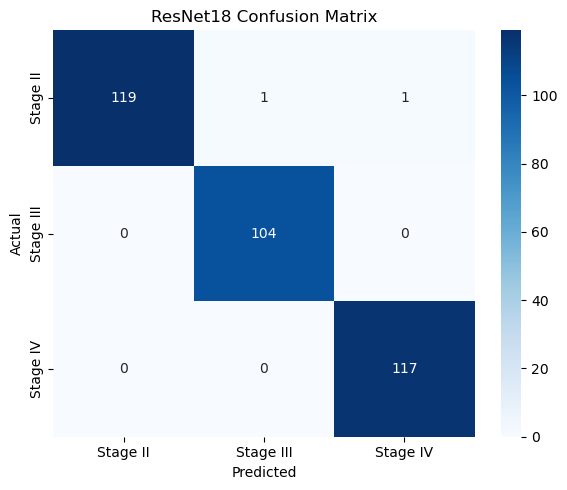

In [58]:
validate_model(model, val_loader, device, model_name="ResNet18")


📊 Classification Report for EfficientNetB0:

              precision    recall  f1-score   support

    Stage II     1.0000    0.9917    0.9959       121
   Stage III     1.0000    1.0000    1.0000       104
    Stage IV     0.9915    1.0000    0.9957       117

    accuracy                         0.9971       342
   macro avg     0.9972    0.9972    0.9972       342
weighted avg     0.9971    0.9971    0.9971       342



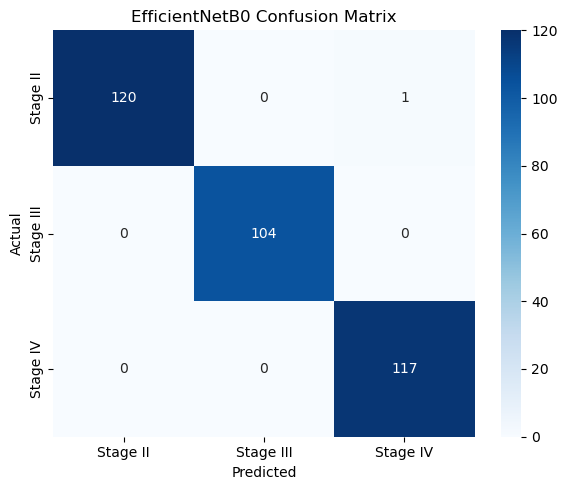

In [60]:
validate_model(model, val_loader, device, model_name="EfficientNetB0")



📊 Classification Report for ConvNeXt-Tiny:

              precision    recall  f1-score   support

    Stage II     1.0000    0.9835    0.9917       121
   Stage III     0.9905    1.0000    0.9952       104
    Stage IV     0.9915    1.0000    0.9957       117

    accuracy                         0.9942       342
   macro avg     0.9940    0.9945    0.9942       342
weighted avg     0.9942    0.9942    0.9941       342



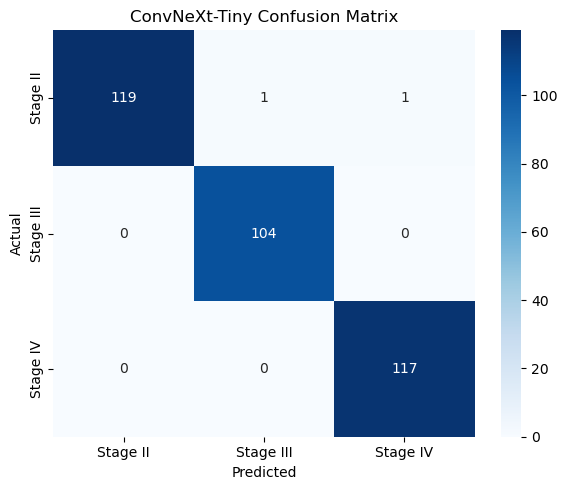

In [61]:
validate_model(model, val_loader, device, model_name="ConvNeXt-Tiny")

In [79]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [81]:
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision.models import resnet18, efficientnet_b0, convnext_tiny


In [83]:
model_resnet = resnet18(weights="IMAGENET1K_V1")
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 3)
model_resnet.to("cuda" if torch.cuda.is_available() else "cpu")

summary(model_resnet, input_size=(1, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [85]:
model_effnet = efficientnet_b0(weights="IMAGENET1K_V1")
model_effnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
model_effnet.classifier[1] = nn.Linear(model_effnet.classifier[1].in_features, 3)
model_effnet.to("cuda" if torch.cuda.is_available() else "cpu")

summary(model_effnet, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             288
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [87]:
model_convnext = convnext_tiny(weights="IMAGENET1K_V1")
model_convnext.features[0][0] = nn.Conv2d(1, 96, kernel_size=4, stride=4)
model_convnext.classifier[2] = nn.Linear(model_convnext.classifier[2].in_features, 3)
model_convnext.to("cuda" if torch.cuda.is_available() else "cpu")

summary(model_convnext, input_size=(1, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           1,632
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
        LayerNorm-14           [-1, 56,

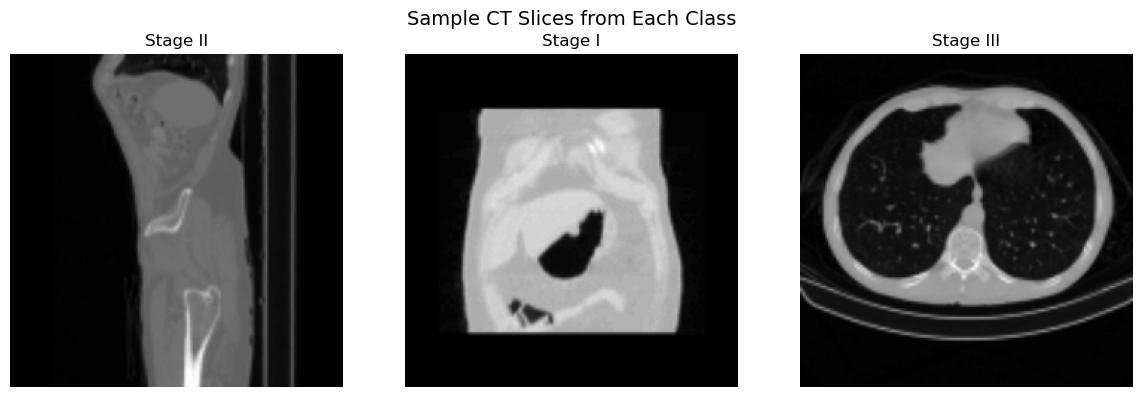

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
dataset = CTSliceDataset(r"F:\INT500\CLAUDE\processed_data\metadata.csv", augment=False)

# Label mapping
label_names = {0: "Stage II", 1: "Stage III", 2: "Stage IV"}
seen = set()

plt.figure(figsize=(12, 4))

# Loop through dataset and find one example of each class
for idx in range(len(dataset)):
    image, label = dataset[idx]
    label = label.item()
    if label not in seen:
        seen.add(label)
        plt.subplot(1, 3, len(seen))
        plt.imshow(image.squeeze(0), cmap='gray')
        plt.title(label_names[label])
        plt.axis('off')
    if len(seen) == 3:
        break

plt.suptitle("Sample CT Slices from Each Class", fontsize=14)
plt.tight_layout()
plt.show()
